# Minimal QNN (Angle Encoding) - Linear Toy Dataset

Goal: Implement a minimal variational quantum classifier (QNN) for a linearly separable 2D dataset.
We use:
- 2 qubits (one per feature)
- fixed Angle Encoding
- a small trainable variational ansatz
- expectation value $\langle Z_0\rangle$ as prediction
- classical optimization (COBYLA)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import sys

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.encodings import AngleEncoding
from src.qnn import AnsatzConfig, build_qnn_circuit, predict_value, mse_loss, train_qnn
from src.data import make_linear, standardize_fit_transform

GLOBAL_SEED = 0
rng = np.random.default_rng(GLOBAL_SEED)

RESULTS_DIR = PROJECT_ROOT / "results" / "qnn"
RESULTS_DIR.mkdir(exist_ok=True)
CIRCUITS_DIR = RESULTS_DIR / "circuits"
CIRCUITS_DIR.mkdir(parents=True, exist_ok=True)

In [18]:
X, y01 = make_linear(n=200, seed=GLOBAL_SEED, noise=0.30)
y = 2 * y01 - 1  # map {0,1} -> {-1,+1}

Xn, _ = standardize_fit_transform(X, X)

print("Xn shape:", Xn.shape, "| y shape:", y.shape)

Xn shape: (200, 2) | y shape: (200,)


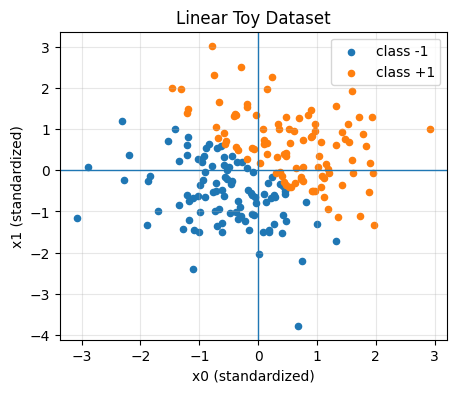

In [19]:
plt.figure(figsize=(5, 4))
plt.scatter(Xn[y == -1, 0], Xn[y == -1, 1], s=20, label="class -1")
plt.scatter(Xn[y == +1, 0], Xn[y == +1, 1], s=20, label="class +1")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("x0 (standardized)")
plt.ylabel("x1 (standardized)")
plt.title("Linear Toy Dataset")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / "02_dataset_linear.png", dpi=1000)
plt.show()

## Model definition

We define a minimal QNN:
1) Encode the 2D input $x$ via Angle Encoding (fixed, no trainable parameters).
2) Apply a small trainable variational ansatz $U(\theta)$.
3) Measure the expectation value $\langle Z_0\rangle$ which lies in $[-1, 1]$.
4) Train $\theta$ to minimize MSE between prediction $\langle Z_0\rangle$ and labels in $\{-1, +1\}$.

In [12]:
encoder = AngleEncoding()
ansatz_cfg = AnsatzConfig(n_qubits=2, layers=2)

theta_test = rng.uniform(-0.2, 0.2, size=ansatz_cfg.n_qubits * ansatz_cfg.layers)
qc_test = build_qnn_circuit(encoder, Xn[0], theta_test, ansatz_cfg)
fig = qc_test.draw(output="mpl")
fig.savefig(CIRCUITS_DIR / "02_circuit_angle.png")
print(qc_test.draw(output="text"))


        ┌───────┐   ┌─────────────┐     ┌──────────────┐
q_0: ───┤ Ry(π) ├───┤ Ry(0.12531) ├──■──┤ Ry(0.042654) ├
     ┌──┴───────┴──┐└┬────────────┤┌─┴─┐├──────────────┤
q_1: ┤ Ry(-2.1423) ├─┤ Ry(0.1651) ├┤ X ├┤ Ry(0.091799) ├
     └─────────────┘ └────────────┘└───┘└──────────────┘


In [5]:
def predict_label(x, theta):
    return +1 if predict_value(encoder, x, theta, ansatz_cfg=ansatz_cfg) >= 0 else -1

print("pred value:", predict_value(encoder, Xn[0], theta_test, ansatz_cfg=ansatz_cfg), "true:", y[0])


pred value: 0.4521154720885021 true: -1


In [6]:
def loss(theta, X, y):
    return mse_loss(encoder, theta, X, y, ansatz_cfg=ansatz_cfg)

print("loss(theta_test):", loss(theta_test, Xn[:20], y[:20]))


loss(theta_test): 1.6165859882128912


In [7]:
train_res = train_qnn(encoder, Xn, y, seed=GLOBAL_SEED, maxiter=100, ansatz_cfg=ansatz_cfg)
theta_star = train_res.theta_star
loss_history = train_res.loss_history

print("Optimization success:", train_res.success)
if not train_res.success and train_res.message is not None:
    print(f"	{train_res.message}")

print("Final loss:", loss(theta_star, Xn, y))


Optimization success: True
Final loss: 0.9985097698755274


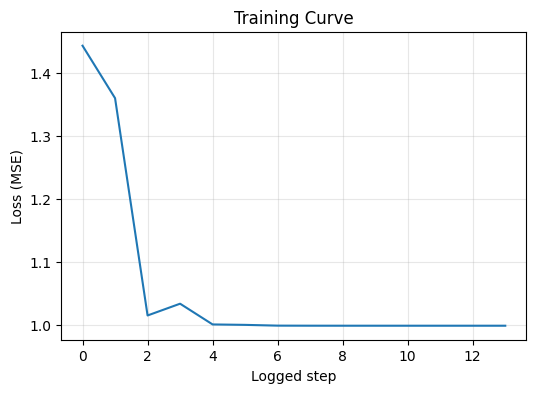

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Logged step")
plt.ylabel("Loss (MSE)")
plt.title("Training Curve")
plt.grid(alpha=0.3)
plt.savefig(RESULTS_DIR / "02_training_curve.png")
plt.show()

In [9]:
preds = np.array([predict_label(x, theta_star) for x in Xn])
acc = float(np.mean(preds == y))
print("Training accuracy:", acc)

Training accuracy: 0.52


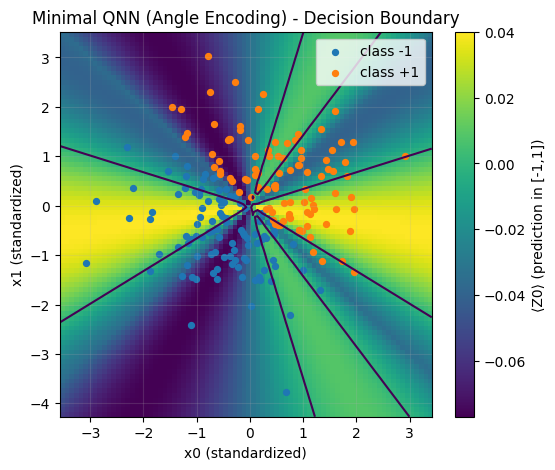

In [14]:
def plot_decision_boundary(X, y, theta, title="Decision boundary"):
    # Grid limits
    x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Grid
    xs = np.linspace(x0_min, x0_max, 80)
    ys = np.linspace(x1_min, x1_max, 80)
    xx, yy = np.meshgrid(xs, ys)

    # Evaluate model on grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    vals = np.array([predict_value(encoder, p, theta, ansatz_cfg=ansatz_cfg) for p in grid], dtype=float)
    zz = vals.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    im = plt.imshow(
        zz,
        origin="lower",
        extent=[x0_min, x0_max, x1_min, x1_max],
        aspect="auto"
    )
    plt.colorbar(im, label="⟨Z0⟩ (prediction in [-1,1])")

    # Decision boundary at 0
    plt.contour(xx, yy, zz, levels=[0.0])

    # Data points
    plt.scatter(X[y == -1, 0], X[y == -1, 1], s=18, label="class -1")
    plt.scatter(X[y == +1, 0], X[y == +1, 1], s=18, label="class +1")

    plt.xlabel("x0 (standardized)")
    plt.ylabel("x1 (standardized)")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.savefig(RESULTS_DIR / "02_decision_boundary_angle.png")
    plt.show()

plot_decision_boundary(Xn, y, theta_star, title="Minimal QNN (Angle Encoding) - Decision Boundary")